# Check if the GPU is beeing detected by Tensorflow

In [30]:
!python --version
import os
# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print("\nTensoflow version = "+tf.__version__)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()[1]

Python 3.8.0

Tensoflow version = 2.5.0


name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6248464384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10038883412300865717
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5"

# Import the data and print how many images we have

In [60]:
import pathlib
import shutil
data_dir_path = "."
data_dir = pathlib.Path(data_dir_path + "/obj/").with_suffix('')
image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

1510


# Import libraries used for processing the images

In [61]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

obj\193-with-mask.jpg


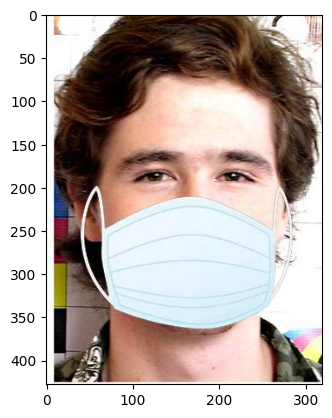

In [62]:
# an example image of masked person
sample_img_path = str(image_files[100])
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.show()

# example of annotation coordinates

In [63]:
sample_annotation_path = sample_img_path[0:-4] + '.txt'
with open(sample_annotation_path) as f:
    print(f.readlines())

['0 0.5171875 0.5268691588785047 0.671875 0.6799065420560748\n']


# Data preprocessing
### Here we're gonna prepare the data to be trained, to do that we will define a function that do Four things:
1. We will focus on images that have only one object to be detected, and drop the rest.
2. Check if the image and its annotated file are exist.
3. Shuffle the data.
4. Split the data into Training, Validation, and Testing. 

In [64]:
import os, random

def list_files(full_data_path = "obj/", image_ext = '.jpg', split_percentage = [70, 20]):
    

    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                    

                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]


In [65]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
904 training files
258 validation files
130 test files


Now we will combine the images and its annotated files.
Also, we will resize the images to 244 to make the training faster.

In [66]:
input_size = 244

def format_image(img, box):
    height, width = img.shape #350 622
    max_size = max(height, width) #622
    r = max_size / input_size # 622/244 = 2.5491803278688523
    new_width = int(width / r) # 622 / 2.5491803278688523 = 244 
    new_height = int(height / r) # 350 / 2.5491803278688523 = 137
    new_size = (new_width, new_height) # (244, 137)
    # array of zeros with = (input_size, input_size), then we resize the image and past it on the array of zeros:
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR) #resized.shape = (137,244)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

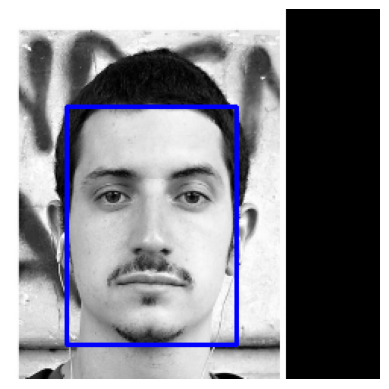

In [67]:
temp_img = cv.imread("obj/149.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.5171875, 0.5911214953271028, 0.621875, 0.6495327102803738]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

In [69]:
def data_load(files, full_data_path = "obj/", image_ext = ".jpg"):
    X = [] #images after resize and normalize
    Y = [] #coordinates and labels

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255. #normalize the image
        box = np.asarray(box, dtype=float) / input_size #normalize the coordinates because 'format_image' will return real values of coordinates
        label = np.append(box, k) #label will contain: [coordinates,label]

        X.append(img)
        Y.append(label)

    X = np.array(X) #Tensorflow excpect to receive the image as numpy array
    
    X = np.expand_dims(X, axis=3) #add new dimension for the label
    
    X = tf.convert_to_tensor(X, dtype=tf.float32) #change the images array into tensors.

    Y = tf.convert_to_tensor(Y, dtype=tf.float32) #change the labels array into tensors.
    
    result = tf.data.Dataset.from_tensor_slices((X, Y)) # zip the image and it's label as one tensor.
    

    return result

In [70]:
raw_train_ds = data_load(training_files)

In [71]:
raw_validation_ds = data_load(validation_files)

In [72]:
raw_test_ds = data_load(test_files)

In [73]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [74]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [75]:
train_ds = tune_training_ds(raw_train_ds)

In [76]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [77]:
validation_ds = tune_validation_ds(raw_validation_ds)

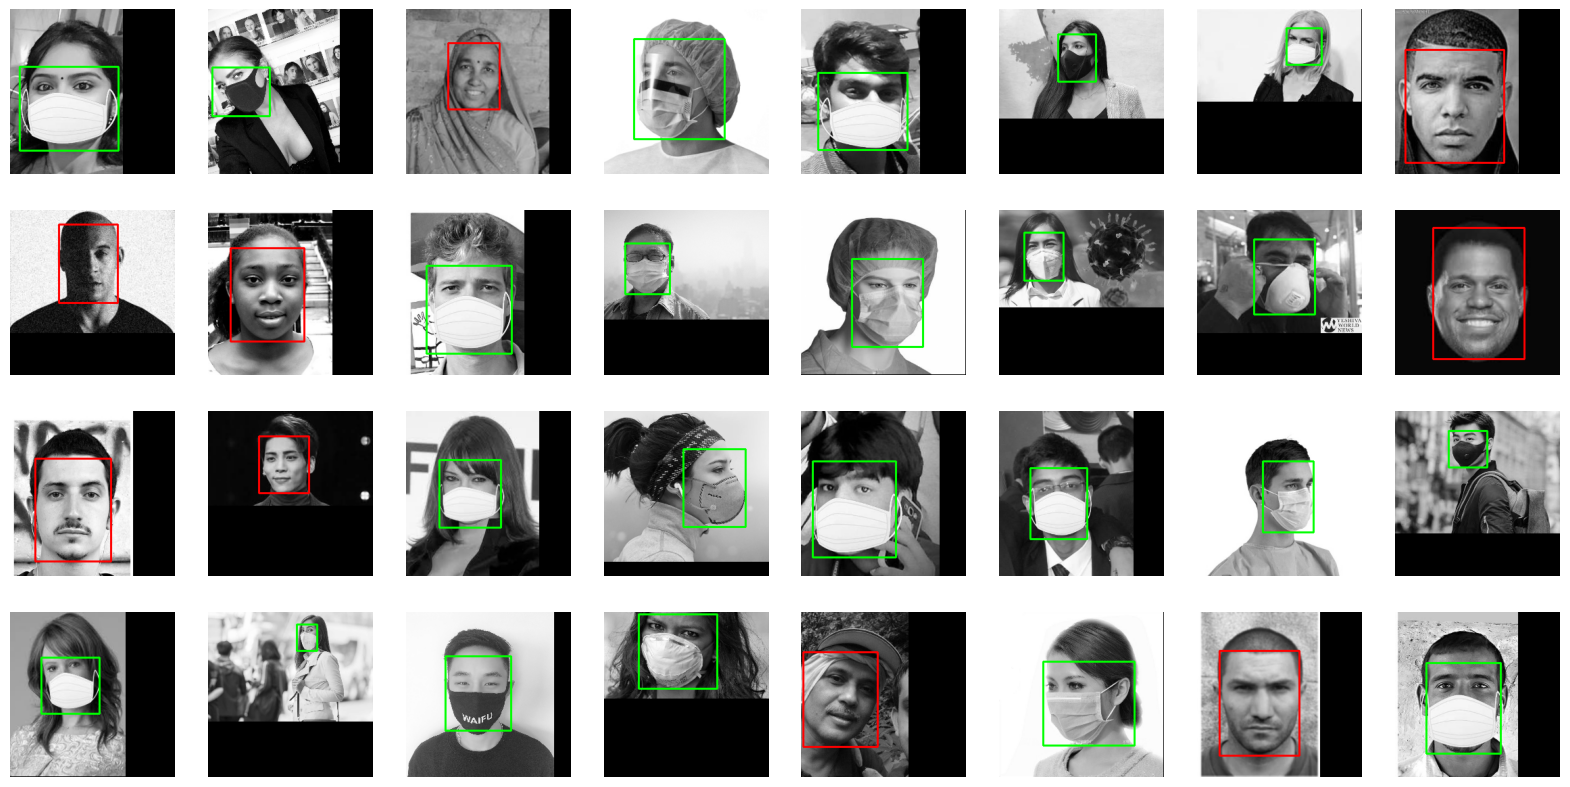

In [87]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (255, 0, 0)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

In [88]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [89]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 242, 242, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 121, 121, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 119, 119, 32) 4640        average_pooling2d[0][0]          
______________________________________________________________________________________________

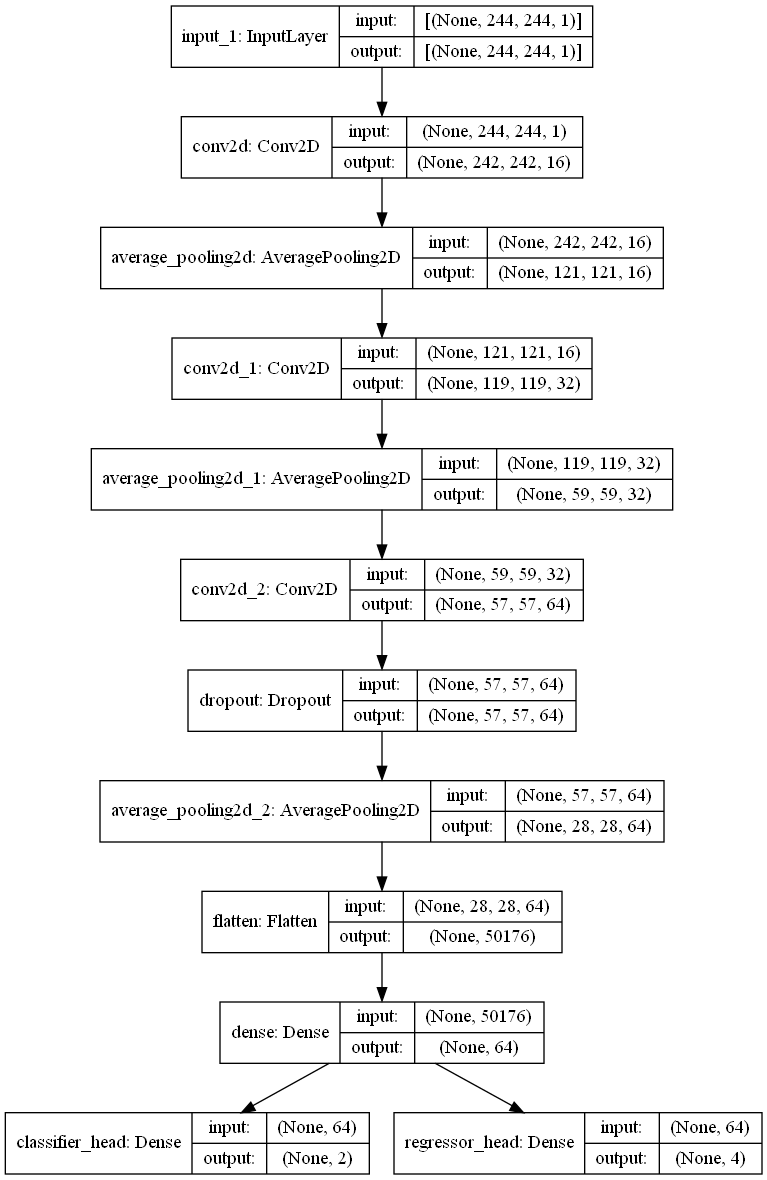

In [90]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [91]:
EPOCHS = 100

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/100
28/28 [==============================] - 9s 35ms/step - loss: 1.0204 - classifier_head_loss: 0.7108 - regressor_head_loss: 0.3096 - classifier_head_accuracy: 0.6440 - regressor_head_mse: 0.3096 - val_loss: 0.6363 - val_classifier_head_loss: 0.6187 - val_regressor_head_loss: 0.0176 - val_classifier_head_accuracy: 0.5625 - val_regressor_head_mse: 0.0176
Epoch 2/100
28/28 [==============================] - 1s 23ms/step - loss: 0.5827 - classifier_head_loss: 0.5686 - regressor_head_loss: 0.0140 - classifier_head_accuracy: 0.7042 - regressor_head_mse: 0.0140 - val_loss: 0.5800 - val_classifier_head_loss: 0.5642 - val_regressor_head_loss: 0.0159 - val_classifier_head_accuracy: 0.7656 - val_regressor_head_mse: 0.0159
Epoch 3/100
28/28 [==============================] - 1s 23ms/step - loss: 0.5334 - classifier_head_loss: 0.5153 - regressor_head_loss: 0.0181 - classifier_head_accuracy: 0.7835 - regressor_head_mse: 0.0181 - val_loss: 0.5698 - val_classifier_head_loss: 0.5500 - val_re

28/28 [==============================] - 1s 24ms/step - loss: 0.0368 - classifier_head_loss: 0.0262 - regressor_head_loss: 0.0106 - classifier_head_accuracy: 0.9911 - regressor_head_mse: 0.0106 - val_loss: 0.5825 - val_classifier_head_loss: 0.5643 - val_regressor_head_loss: 0.0183 - val_classifier_head_accuracy: 0.8438 - val_regressor_head_mse: 0.0183
Epoch 24/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0454 - classifier_head_loss: 0.0342 - regressor_head_loss: 0.0112 - classifier_head_accuracy: 0.9900 - regressor_head_mse: 0.0112 - val_loss: 0.5714 - val_classifier_head_loss: 0.5508 - val_regressor_head_loss: 0.0206 - val_classifier_head_accuracy: 0.8438 - val_regressor_head_mse: 0.0206
Epoch 25/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0342 - classifier_head_loss: 0.0237 - regressor_head_loss: 0.0106 - classifier_head_accuracy: 0.9922 - regressor_head_mse: 0.0106 - val_loss: 0.5990 - val_classifier_head_loss: 0.5794 - val_regressor_he

28/28 [==============================] - 1s 23ms/step - loss: 0.0680 - classifier_head_loss: 0.0537 - regressor_head_loss: 0.0143 - classifier_head_accuracy: 0.9877 - regressor_head_mse: 0.0143 - val_loss: 0.4900 - val_classifier_head_loss: 0.4677 - val_regressor_head_loss: 0.0222 - val_classifier_head_accuracy: 0.8594 - val_regressor_head_mse: 0.0222
Epoch 46/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0260 - classifier_head_loss: 0.0172 - regressor_head_loss: 0.0088 - classifier_head_accuracy: 0.9978 - regressor_head_mse: 0.0088 - val_loss: 0.6122 - val_classifier_head_loss: 0.5958 - val_regressor_head_loss: 0.0164 - val_classifier_head_accuracy: 0.8438 - val_regressor_head_mse: 0.0164
Epoch 47/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0176 - classifier_head_loss: 0.0110 - regressor_head_loss: 0.0066 - classifier_head_accuracy: 0.9967 - regressor_head_mse: 0.0066 - val_loss: 0.7810 - val_classifier_head_loss: 0.7634 - val_regressor_he

28/28 [==============================] - 1s 26ms/step - loss: 0.0052 - classifier_head_loss: 0.0021 - regressor_head_loss: 0.0031 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0031 - val_loss: 0.6945 - val_classifier_head_loss: 0.6789 - val_regressor_head_loss: 0.0156 - val_classifier_head_accuracy: 0.8594 - val_regressor_head_mse: 0.0156
Epoch 68/100
28/28 [==============================] - 1s 25ms/step - loss: 0.0058 - classifier_head_loss: 0.0026 - regressor_head_loss: 0.0032 - classifier_head_accuracy: 0.9989 - regressor_head_mse: 0.0032 - val_loss: 0.7149 - val_classifier_head_loss: 0.6988 - val_regressor_head_loss: 0.0161 - val_classifier_head_accuracy: 0.8438 - val_regressor_head_mse: 0.0161
Epoch 69/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0057 - classifier_head_loss: 0.0027 - regressor_head_loss: 0.0030 - classifier_head_accuracy: 0.9989 - regressor_head_mse: 0.0030 - val_loss: 0.6957 - val_classifier_head_loss: 0.6804 - val_regressor_he

28/28 [==============================] - 1s 23ms/step - loss: 0.0030 - classifier_head_loss: 8.7619e-04 - regressor_head_loss: 0.0021 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0021 - val_loss: 0.7730 - val_classifier_head_loss: 0.7593 - val_regressor_head_loss: 0.0136 - val_classifier_head_accuracy: 0.8594 - val_regressor_head_mse: 0.0136
Epoch 90/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0025 - classifier_head_loss: 3.2788e-04 - regressor_head_loss: 0.0022 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0022 - val_loss: 0.7262 - val_classifier_head_loss: 0.7121 - val_regressor_head_loss: 0.0141 - val_classifier_head_accuracy: 0.8594 - val_regressor_head_mse: 0.0141
Epoch 91/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0030 - classifier_head_loss: 8.3252e-04 - regressor_head_loss: 0.0021 - classifier_head_accuracy: 1.0000 - regressor_head_mse: 0.0021 - val_loss: 0.7399 - val_classifier_head_loss: 0.7264 - val_

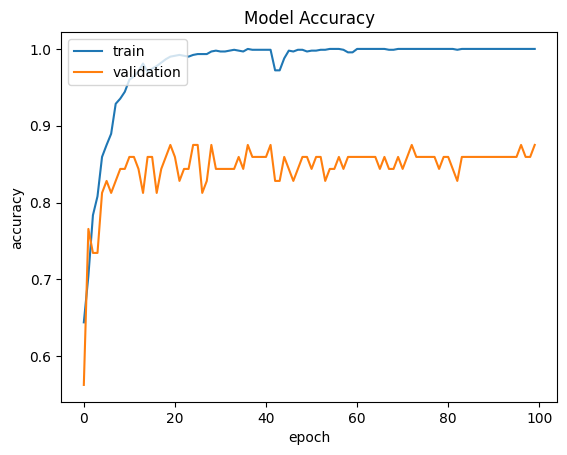

In [94]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

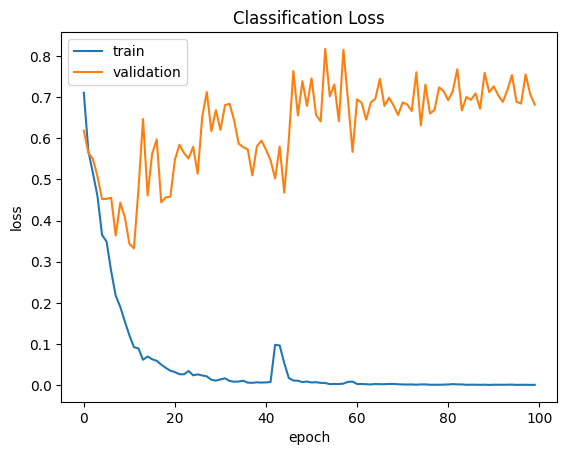

In [95]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

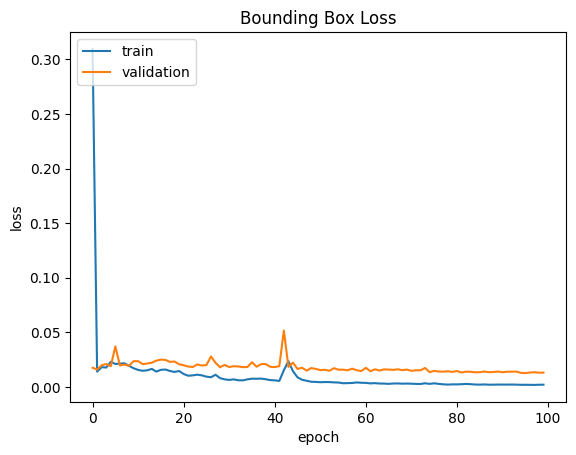

In [96]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [97]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [98]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

20


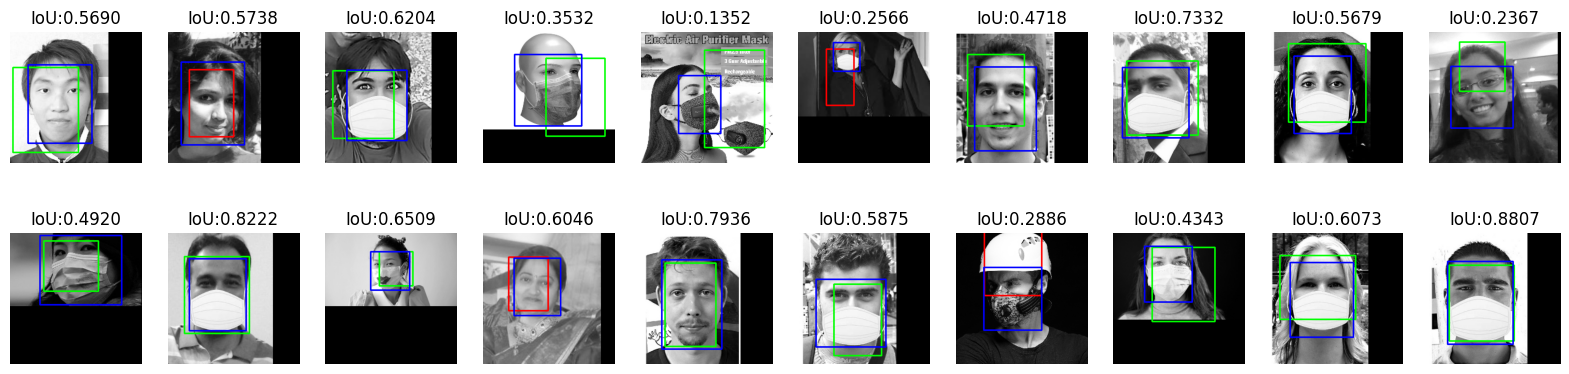

In [159]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]
    aaa = type(image)
    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

In [92]:
#!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets
